# Class-discriminative attention maps for Vision Transformer

In [72]:
try:
    import google.colab
    print("Running on Colab, cloning reposityory and installing requirements...")
    !git clone https://github.com/lenbrocki/CDAM
    import os
    os.chdir("./CDAM")
    !pip install -r requirements_colab.txt --quiet
except ImportError:
    pass

In [73]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import cmasher as cmr
import matplotlib.colors as clr
from glob import glob
from tqdm.notebook import tqdm
from LitModel import LitModel
import numpy as np
import seaborn as sns
import gc
from types import MethodType
import copy
import seaborn as sns
import pandas as pd
from classes import IMAGENET2012_CLASSES as imgnet_dict
import pickle
import os
from functools import partial
from torch import nn

In [74]:
device = "cuda"

In [75]:
imgnet_dict_inv = {v: k for k, v in imgnet_dict.items()}
idx2class = {i: j for i, j in enumerate(imgnet_dict.values())}
class2idx = {i: j for j, i in idx2class.items()}

Load Pytorch Lightning Model trained on ImageNet 

You can use your own model but have to make sure that you adjust ```patch_size```, ```image_size``` and ```final_block_norm1```.

With ```final_block_norm1``` we define the target for the gradients and activations that are used to obtain CDAM scores. \
CDAM operates on the final transformer block, where norm1 is the layer normalization before tokens enter the attention layer.

In [76]:
lit_model = (
    LitModel.load_from_checkpoint(
        "best-checkpoint-full-imgnet-augment.ckpt"
    )
    .to(device)
    .eval()
)
# Here we define the model. You can replace it with your own model 
# This is ViT backbone with head=nn.Identity()
model = lit_model.model
# Set the head to be the linear classifier 
model.head = lit_model.linear

patch_size = 8
img_size = (490, 490)
final_block_norm1 = model.blocks[-1].norm1

Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_dino_main


Override two methods from the Dino ViT implementation to:
1. Include the model head in the forward pass
2. Allow us to remove patch embeddings after the positional encoding is added for token ablation study

In [77]:

def forward_new(self, x, remove=None):
    x = self.prepare_tokens(x, remove)
    for blk in self.blocks:
        x = blk(x)
    x = self.norm(x)
    x = self.head(x)
    return x[:, 0]

def prepare_tokens_new(self, x, remove=None):
    B, nc, w, h = x.shape
    x = self.patch_embed(x)  # patch linear embedding

    # add the [CLS] token to the embed patch tokens
    cls_tokens = self.cls_token.expand(B, -1, -1)
    x = torch.cat((cls_tokens, x), dim=1)

    # add positional encoding to each token
    x = x + self.interpolate_pos_encoding(x, w, h)
    x = self.pos_drop(x)

    # remove patch embeddings defined in "remove", this is the new part
    num_patches = x.shape[1]
    if remove != None:
        t = torch.arange(num_patches)
        idx_to_keep = [i for j, i in enumerate(t) if j not in remove]
        x = x[:, idx_to_keep, :]
    return x

model.forward = MethodType(forward_new, model)
model.prepare_tokens = MethodType(prepare_tokens_new, model)

### Image loading and utils

In [78]:
transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]
    )
def load_img(image_path):
    """Returns the image as resized and normalized tensor and as original (only resized)"""
    with open(image_path, "rb") as f:
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize(img_size)
        original_img = copy.deepcopy(img)

    img = transform(img).to(device)

    # make image divisible by patch size
    w, h = (
        img.shape[1] - img.shape[1] % patch_size,
        img.shape[2] - img.shape[2] % patch_size,
    )
    img = img[:, :w, :h].unsqueeze(0)
    img.requires_grad = True
    return img, original_img

In [79]:
# Define custom diverging color map
mycmap = clr.LinearSegmentedColormap.from_list(
    "Random gradient 1030",
    (
        (0.000, (0.000, 0.890, 1.000)),
        (0.370, (0.263, 0.443, 0.671)),
        (0.500, (0.000, 0.000, 0.000)),
        (0.630, (0.545, 0.353, 0.267)),
        (1.000, (1.000, 0.651, 0.000)),
    ),
)

In [80]:
def get_cmap(heatmap):
    """Return a diverging colormap, such that 0 is at the center(black)"""
    if heatmap.min() > 0 and heatmap.max() > 0:
        bottom = 0.5
        top = 1.0
    elif heatmap.min() < 0 and heatmap.max() < 0:
        bottom = 0.0
        top = 0.5
    else:
        bottom = 0.5 - abs((heatmap.min() / abs(heatmap).max()) / 2)
        top = 0.5 + abs((heatmap.max() / abs(heatmap).max()) / 2)
    return cmr.get_sub_cmap(mycmap, bottom, top)

In [81]:
def plot_results(original, maps, savename=None, figsize=(9, 9)):
    """Using matplotlib, plot the original image and the relevance maps"""
    plt.figure(figsize=figsize)
    num_plots = 1 + len(maps)

    plt.subplot(1, num_plots, 1)
    plt.imshow(original)
    plt.axis("off")
    for i, m in enumerate(maps):
        plt.subplot(1, num_plots, i + 2)
        plt.imshow(m, cmap=get_cmap(m))
        plt.axis("off")
    plt.subplots_adjust(wspace=0.005, hspace=0)
    # save the plot to a file, cropped to only the image
    if savename:
        plt.savefig(f"relevance_maps/{savename}.png", bbox_inches="tight", pad_inches=0)
    plt.show()

In [82]:
def print_top_classes(predictions, **kwargs):
    """Print Top-5 predictions"""
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(idx2class[cls_idx])
        if len(idx2class[cls_idx]) > max_str_len:
            max_str_len = len(idx2class[cls_idx])

    print("Top 5 classes:")
    for cls_idx in class_indices:
        output_string = "\t{} : {}".format(cls_idx, idx2class[cls_idx])
        output_string += " " * (max_str_len - len(idx2class[cls_idx])) + "\t\t"
        output_string += "value = {:.3f}\t prob = {:.1f}%".format(
            predictions[0, cls_idx], 100 * prob[0, cls_idx]
        )
        print(output_string)

### Functions to obtain attention maps

In [83]:
def get_attention_map(model, sample_img, head=None, return_raw=False):
    """This returns the attentions when CLS token is used as query in the last attention layer, averaged over all attention heads"""
    attentions = model.get_last_selfattention(sample_img)

    w_featmap = sample_img.shape[-2] // patch_size
    h_featmap = sample_img.shape[-1] // patch_size

    nh = attentions.shape[1]  # number of heads


    # this extracts the attention when cls is used as query
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
    if return_raw:
        return torch.mean(attentions, dim=0).squeeze().detach().cpu().numpy()

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = torch.nn.functional.interpolate(
        attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest"
    )[0]
    if head == None:
        mean_attention = torch.mean(attentions, dim=0).squeeze().detach().cpu().numpy()
        return mean_attention
    else:
        return attentions[head].squeeze().detach().cpu().numpy()

In [84]:
def get_CDAM(class_score, activation, grad, clip=False, return_raw=False):
    """The class_score can either be the activation of a neuron in the prediction vector or a similarity score between the latent representations of a concept and a sample"""
    class_score.backward()
    # Token 0 is CLS and others are 60x60 image patch tokens
    tokens = activation["last_att_in"][1:]
    grads = grad["last_att_in"][0][0, 1:]

    attention_scores = torch.tensor(
        [torch.dot(tokens[i], grads[i]) for i in range(len(tokens))]
    )

    if return_raw:
        return attention_scores
    else:
        # clip for higher contrast plots
        if clip:
            attention_scores = torch.clamp(
                attention_scores,
                min=torch.quantile(attention_scores, 0.001),
                max=torch.quantile(attention_scores, 0.999),
            )
        w = int(np.sqrt(attention_scores.squeeze().shape[0]))
        attention_scores = attention_scores.reshape(w, w)

        return torch.nn.functional.interpolate(
            attention_scores.unsqueeze(0).unsqueeze(0),
            scale_factor=patch_size,
            mode="nearest",
        ).squeeze()

### Define hooks for token activations and gradients before they enter last attention

In [85]:
# function to extract activation
activation = {}


def get_activation(name):
    def hook(model, input, output):
        activation[name] = output[0].detach()

    return hook


# function to extract gradients
grad = {}


def get_gradient(name):
    def hook(model, input, output):
        grad[name] = output

    return hook

In [86]:
# We are calculating the gradients wrt the normalized inputs to the final attention layer
# In the Dino implementation the normalization happens in the final block,
# whereas in the original Transformer paper https://arxiv.org/pdf/1706.03762.pdf the normalization is done at the end of each transformer block
activation_hook = final_block_norm1.register_forward_hook(
    get_activation("last_att_in")
)
grad_hook = final_block_norm1.register_full_backward_hook(
    get_gradient("last_att_in")
)

In [87]:
def get_maps(model, img, target_class, return_raw=False, clip=False):
    """Wrapper function to get the attention map and the concept map for a given image and target class"""
    class_idx = class2idx[target_class]
    pred = model(img)
    class_attention_map = get_CDAM(
        class_score=pred[0][class_idx],
        activation=activation,
        grad=grad,
        return_raw=return_raw,
        clip=clip
    )
    attention_map = get_attention_map(model, img, return_raw=return_raw)
    return attention_map, class_attention_map

### Visualizing concept score

In [88]:
def get_concept_vector(imgs, model):
    """Get the concept vector from a list of images defining the concept"""
    with torch.no_grad():
        concepts_embeddings = [model(load_img(i)[0]) for i in imgs]
        concept_vector = torch.mean(torch.stack(concepts_embeddings).squeeze(), axis=0)
    return concept_vector

In [89]:
model.head = torch.nn.Identity()

In [90]:
violins = ["images/violin1.jpg", "images/violin2.jpg"]
horns = ["images/horn1.jpg", "images/horn2.jpg"]

In [91]:
def plot_concept(original, sample_img, concept_imgs):
    concept_vector = get_concept_vector(concept_imgs, model)
    sample_img.requires_grad = True
    sample_vector = model(sample_img)
    concept_score = torch.dot(sample_vector.squeeze(), concept_vector.squeeze())
    concept_map = get_CDAM(
        class_score=concept_score, activation=activation, grad=grad, clip=True
    )

    attention_map = get_attention_map(model, sample_img)
    plot_results(original=original, maps=[concept_map, attention_map])

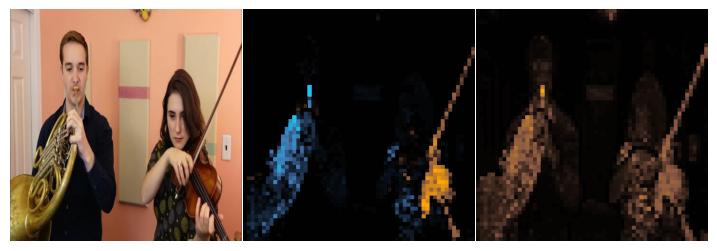

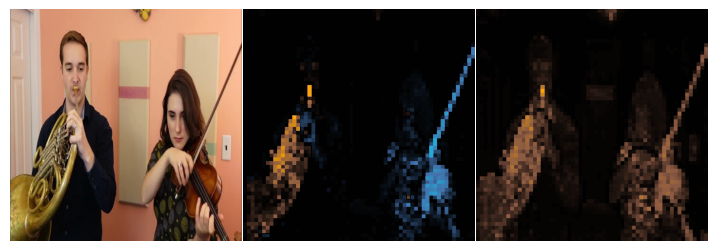

In [92]:
sample_img, original = load_img("images/hornviolin.jpg")
plot_concept(original, sample_img, violins)
plot_concept(original, sample_img, horns)

### Visualizing class score 

In [93]:
model.head = lit_model.linear

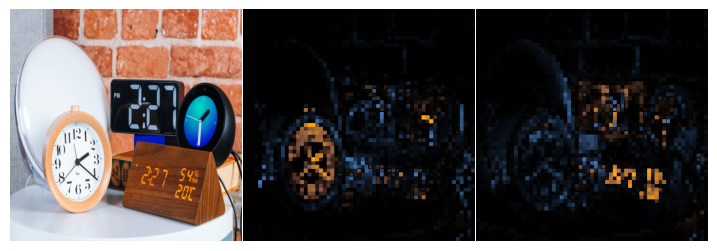

In [94]:
img_path = "images/clocks.jpg"
sample_img, original_img = load_img(img_path)
sample_img.requires_grad = True

attention_map, class_attention_map1 = get_maps(model, sample_img, "analog clock", clip=True)
attention_map, class_attention_map2 = get_maps(model, sample_img, "digital clock", clip=True)

plot_results(original_img, [class_attention_map1, class_attention_map2])

### Comparison method

As comparison method we use Transformer-Explainability (in our paper refered to as Relevance Propagation) by Chefer et al. \
The below code is taken from their repositories, with a small change to prevent memory leakage

https://github.com/hila-chefer/Transformer-Explainability \
https://github.com/hila-chefer/Transformer-MM-Explainability 

In [95]:
# check if Transformer_Explainability exists
try:
    import Transformer_Explainability
except:
    !git clone https://github.com/hila-chefer/Transformer-Explainability.git
    !mv Transformer-Explainability Transformer_Explainability

In [96]:
# rule 5 from paper
def avg_heads(cam, grad):
    cam = cam.reshape(-1, cam.shape[-2], cam.shape[-1])
    grad = grad.reshape(-1, grad.shape[-2], grad.shape[-1])
    cam = grad * cam
    cam = cam.clamp(min=0).mean(dim=0)
    return cam


# rule 6 from paper
def apply_self_attention_rules(R_ss, cam_ss):
    R_ss_addition = torch.matmul(cam_ss, R_ss)
    return R_ss_addition


def generate_relevance(model, input, index=None):
    output = model(input, register_hook=True)
    if index is None:
        index = np.argmax(output.cpu().data.numpy(), axis=-1)

    one_hot = torch.zeros((1, output.size()[-1]), dtype=torch.float32).cuda()
    one_hot[0, index] = 1
    one_hot_vector = one_hot
    one_hot = torch.sum(one_hot * output)
    model.zero_grad()
    one_hot.backward()
    one_hot.detach_()
    output.detach_()
    num_tokens = model.blocks[0].attn.get_attention_map().shape[-1]
    R = torch.eye(num_tokens, num_tokens).cuda()
    for blk in model.blocks:
        grad = blk.attn.get_attn_gradients()
        cam = blk.attn.get_attention_map()
        cam = avg_heads(cam, grad)
        cam.detach_()
        R += apply_self_attention_rules(R.cuda(), cam.cuda())
    gc.collect()
    torch.cuda.empty_cache()
    return R[0, 1:]

In [97]:
os.makedirs("Transformer_Explainability", exist_ok=True)
torch.save(model.state_dict(), "Transformer_Explainability/myvit.pt")

To calculate the ```Transformer_Explainability``` scores we have to use their ViT implementation, because the Dino implementation we have been using so far does not define the ```attn.get_attn_gradients()``` and ```attn.get_attention_map()```

In [114]:
# check if working directory is Transformer_Explainability
if os.getcwd().split("/")[-1] != "Transformer_Explainability":
    os.chdir(f'./Transformer_Explainability')
from Transformer_Explainability.baselines.ViT.ViT_new import VisionTransformer


# Initialize the model from the Transformer_Explainability repo and load the weights from the Pytorch Lightning model
model_compare = VisionTransformer(
    img_size=(224, 224),
    patch_size=8,
    embed_dim=384,
    depth=12,
    num_heads=6,
    mlp_ratio=4,
    qkv_bias=True,
    norm_layer=partial(nn.LayerNorm, eps=1e-6),
)
model_compare.load_state_dict(torch.load("myvit.pt"), strict=True)
model_compare.cuda()
model_compare.eval()


def generate_visualization(original_image, model_compare, class_index=None, return_raw=False):
    transformer_attribution = generate_relevance(
        model_compare, original_image, index=class_index
    ).detach()
    if return_raw:
        return transformer_attribution
    w = int(np.sqrt(transformer_attribution.shape))

    transformer_attribution = transformer_attribution.reshape(1, 1, w, w)
    transformer_attribution = torch.nn.functional.interpolate(
        transformer_attribution, scale_factor=patch_size, mode="nearest"
    )
    transformer_attribution = (
        transformer_attribution.reshape(w * patch_size, w * patch_size)
        .cuda()
        .data.cpu()
        .numpy()
    )
    return transformer_attribution

In [99]:
def get_compare_map(model, image, target_class, return_raw=False):
    output = model(image.cuda())
    return generate_visualization(image, model_compare=model_compare, class_index=class2idx[target_class], return_raw=return_raw)

Make sure that ```model_compare``` and ```model``` produce the same outputs

Sanity checking that both models give equal outputs
Predictions Dino implementation
Top 5 classes:
	386 : African elephant, Loxodonta africana		value = 18.823	 prob = 83.9%
	101 : tusker                              		value = 17.026	 prob = 13.9%
	385 : Indian elephant, Elephas maximus    		value = 14.496	 prob = 1.1%
	340 : zebra                               		value = 14.445	 prob = 1.1%
	343 : warthog                             		value = 9.607	 prob = 0.0%
Predictions Relevancy Propagation implementation
Top 5 classes:
	386 : African elephant, Loxodonta africana		value = 18.823	 prob = 83.9%
	101 : tusker                              		value = 17.026	 prob = 13.9%
	385 : Indian elephant, Elephas maximus    		value = 14.496	 prob = 1.1%
	340 : zebra                               		value = 14.445	 prob = 1.1%
	343 : warthog                             		value = 9.607	 prob = 0.0%


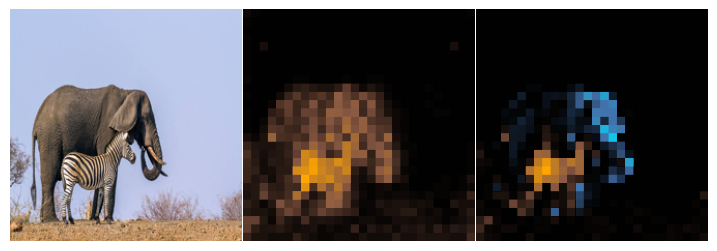

In [100]:
img_size = (224, 224)
target_class = "zebra"
img_path = "../images/elephant-zebra.jpg"
sample_img, original_img = load_img(img_path)
# sample_img.requires_grad = True
print("Sanity checking that both models give equal outputs")
print("Predictions Dino implementation")
print_top_classes(model(sample_img))
attention_map, class_attention_map = get_maps(model, sample_img, target_class)
print("Predictions Relevancy Propagation implementation")
print_top_classes(model_compare(sample_img))
compare_map = generate_visualization(sample_img, model_compare=model_compare, class_index=class2idx[target_class])

plot_results(original_img, [compare_map, class_attention_map])

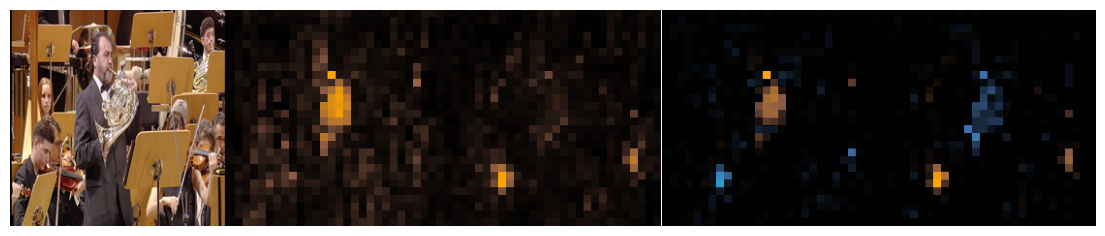

In [101]:
img_path = "../images/horn.jpg"
target_class = "French horn, horn"
sample_img, original_img = load_img(img_path)

attention_map, class_attention_map1 = get_maps(model=model, img=sample_img, target_class=target_class)
compare_map1 = generate_visualization(original_image=sample_img, model_compare=model_compare, class_index=class2idx[target_class])

target_class = "violin, fiddle"

attention_map, class_attention_map2 = get_maps(model=model, img=sample_img, target_class=target_class)
compare_map2 = generate_visualization(original_image=sample_img, model_compare=model_compare, class_index=class2idx[target_class])

plot_results(
    original_img,
    [compare_map1, compare_map2, class_attention_map1, class_attention_map2],
    figsize=(14, 8)
)

### Token ablation study

In [ ]:
# check if working directory is Transformer_Explainability
if os.getcwd().split("/")[-1] != "Transformer_Explainability":
    os.chdir(f'./Transformer_Explainability')

In [102]:
model.head = lit_model.linear

```token_ablation_map()``` removes single patch tokens before they enter the first transformer block and measures the delta in model output for the chosen target class

Since we perform a forward pass for each removed patch token, token_ablation_map() is slow \
Could possibly be sped up by somehow batching the forward passes

In [104]:
def token_ablation_map(img, target_class, show_progress=True):
    pred_delta = []
    pred_orig = model(sample_img)
    B, nc, w, h = img.shape
    range_obj = range(int((w/patch_size)**2))
    if show_progress:
        range_obj = tqdm(range_obj)
    for i in range_obj:
        with torch.no_grad():
            pred = model(sample_img, remove=[i+1])
        pred_delta.append(float(pred_orig[:,target_class] - pred[:,target_class]))
    w = int(np.sqrt(len(pred_delta)))
    return np.array(pred_delta).reshape(w,w)

  0%|          | 0/784 [00:00<?, ?it/s]

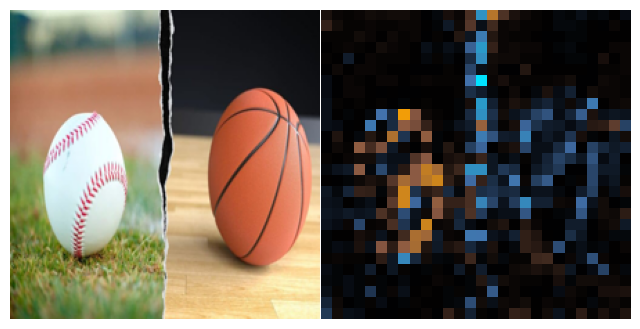

In [105]:
sample_img, original_img = load_img("../images/balls.jpg")
plot_results(original_img, [token_ablation_map(sample_img, class2idx["baseball"])], figsize=(8,8))

Get the relevance scores for 1000 images for the following methods:

TAM: Token ablation map \
CDAM: Class-discriminative attention map \
RP: Relevance Propagation \
AM: Attention Map 

If you want to run these computations yourself you have to download the ImageNet validation dataset and adjust ```imgnet_val_path```. Also, running this cell takes a long time because obtaining TAMs is slow.

We therefore provide below a pickle file that contains pre-computed relevance scores. If you want to just load the pickle file and avoid downloading ImageNet you can skip the cell below.

In [112]:
imgnet_val_path = "/home/ubuntu/datasets/val_images/"
val_images = glob(f"{imgnet_val_path}/*.JPEG")
score_dict_all = {"TAM": [], "CDAM": [], "RP": [], "AM":[]}
num_imgs = 1000
for img_path in tqdm(val_images[:num_imgs]):

    sample_img, original_img = load_img(img_path)
    pred_orig = model(sample_img)
    pred_max = int(torch.argmax(pred_orig))
    att_map, cdam = get_maps(
    model=model, img=sample_img, target_class=idx2class[pred_max], return_raw=True
    )
    compare_map = generate_visualization(sample_img, model_compare=model_compare, class_index=pred_max, return_raw=True)
    score_dict = {i: [] for i in score_dict_all.keys()}
    for i in range(len(cdam)):
        with torch.no_grad():
            pred = model(sample_img, remove=[i+1])
        score_dict["TAM"].append(float(pred_orig[:,pred_max] - pred[:,pred_max]))
        score_dict["CDAM"].append(float(cdam[i]))
        score_dict["AM"].append(float(att_map[i]))
        score_dict["RP"].append(float(compare_map[i]))
    for k in score_dict_all.keys():
        score_dict_all[k].append(score_dict[k])
for k in score_dict_all.keys():
    score_dict_all[k] = np.array(score_dict_all[k])
    
# save score_dict_all as pickle
with open("../score_dict_all.pkl", "wb") as f:
    pickle.dump(score_dict_all, f)

  0%|          | 0/1000 [00:00<?, ?it/s]

You can load the pre-computed ```score_dict_all``` from the provided pickle

In [117]:
with open("../score_dict_all.pkl", "rb") as f:
    score_dict_all = pickle.load(f)

To compare sparsity of the different methods we calculate the ratio of values below a certain threshold per image and average over all images

In [124]:
def get_ratio(scores, t=0.05):
    """Get ratio of pixels scores that are smaller than threshold"""
    cnt = 0
    m = scores.max()
    for i in scores:
        if np.abs(i) < t*m:
            cnt += 1
    return cnt/len(scores)

In [125]:
ratio_dict = {i: [] for i in score_dict_all.keys()}
# Iterate over methods
for key, val in score_dict_all.items():
    # Iterate over images
    for k in val:
        ratio_dict[key].append(get_ratio(k))
ratio_dict = {k: np.mean(v) for k, v in ratio_dict.items()}
print(ratio_dict)

{'TAM': 0.6563125, 'CDAM': 0.8379948979591836, 'RP': 0.49106760204081634, 'AM': 0.5432869897959183}


Create pairwise scatterplots of the scores

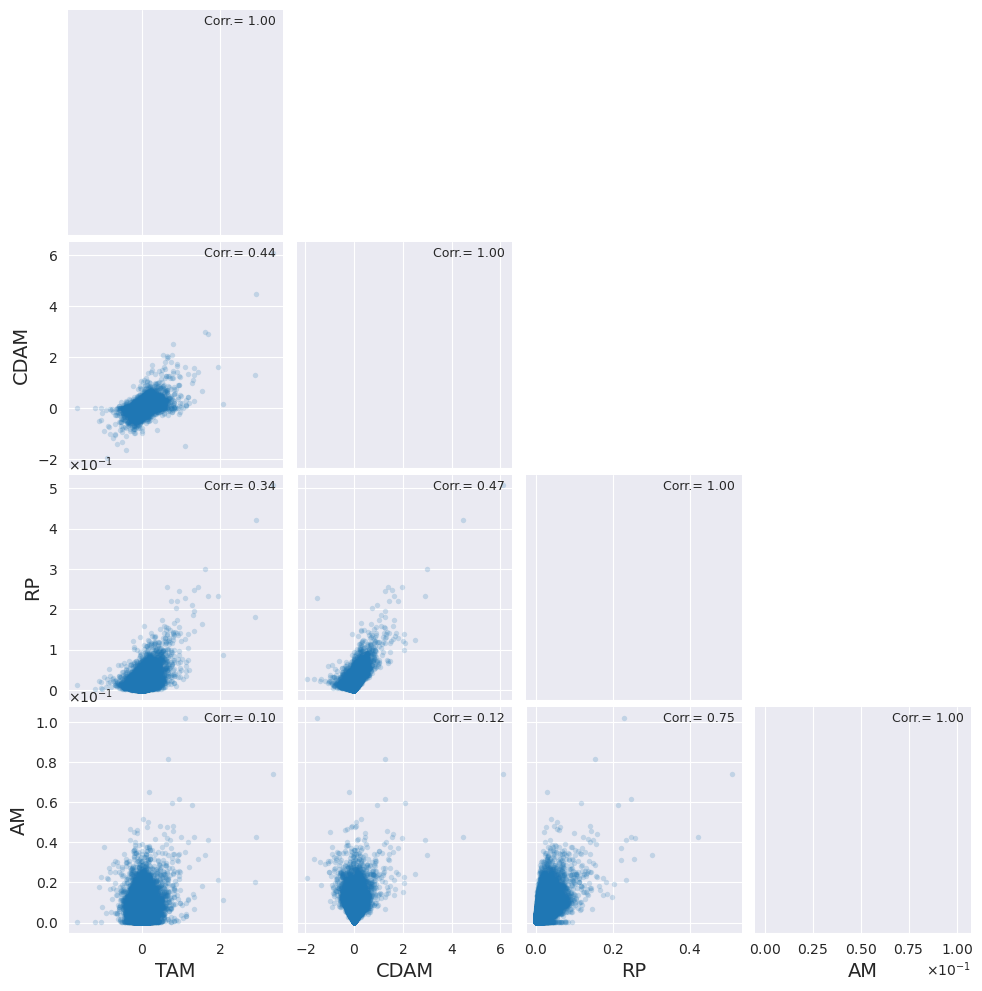

In [121]:
import matplotlib.ticker as mticker
score_dict_all_flat = {k: v.flatten() for k, v in score_dict_all.items()}
df = pd.DataFrame(score_dict_all_flat)
sns.set_style("darkgrid")
g = sns.pairplot(df, corner=True, plot_kws={"alpha": 0.2, "s": 15, "linewidth":0})

# Calculate the correlation matrix
corr = df.corr()

# Annotate the correlation statistics to each plot
for i in range(g.axes.shape[0]):
    for j in range(g.axes.shape[1]):
        if g.axes[i, j]:
            g.axes[i, j].annotate("Corr.= {:.2f}".format(corr.iloc[i, j]), (0.8, 0.95), xycoords='axes fraction', ha='center', va='center', fontsize=9)

# Increase the size of the axis labels and ticks
for ax in g.axes.flatten():
    if ax:
        try:
            ax.set_xlabel(ax.get_xlabel(), fontsize=14)
        except:
            pass
        try:
            ax.set_ylabel(ax.get_ylabel(), fontsize=14)
        except:
            pass
        ax.tick_params(axis='both', which='major', labelsize=10)
        # Format the ticks to scientific notation
        formatter = mticker.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True) 
        formatter.set_powerlimits((-1,1)) 

        # Increase the size of the scientific notation
        ax.xaxis.set_major_formatter(formatter) 
        ax.yaxis.set_major_formatter(formatter)
        ax.xaxis.get_offset_text().set_fontsize(10)
        ax.yaxis.get_offset_text().set_fontsize(10)

for ax in g.diag_axes: 
    ax.set_visible(False)

# plt.show()
os.makedirs("../plots", exist_ok=True)
plt.savefig("../plots/pairplot.png", dpi=300, bbox_inches="tight")

Obtain relevance maps for some images from the ImageNet validation set for visual comparison

In [111]:
results_list = []
for img_path in tqdm(val_images[:6]):
    sample_img, original_img = load_img(img_path)

    predicted_class = idx2class[int(torch.argmax(model(sample_img)))]

    attention_map, cdam = get_maps(model, sample_img, predicted_class)
    rp = generate_visualization(sample_img, model_compare=model_compare, class_index=class2idx[predicted_class])
    tam = token_ablation_map(sample_img, class2idx[predicted_class], show_progress=False)

    results_dict = {"class": predicted_class.split(",")[0], "original": original_img, "maps": [attention_map, cdam, rp, tam]}
    results_list.append(results_dict)

  0%|          | 0/6 [00:00<?, ?it/s]

In [41]:
def plot_examples(results_list):
    plt.figure(figsize=(6, 10))
    num_plots = 1 + len(results_list[0]["maps"])
    map_names = ["AM", "CDAM", "RP", "TAM"]
    j = 1
    for row, res in enumerate(results_list):
        original = res["original"]
        maps = res["maps"]
        plt.subplot(len(results_list), num_plots, j)
        plt.imshow(original)
        plt.title(res["class"])
        plt.axis("off")
        for i, m in enumerate(maps):
            if not isinstance(m, torch.Tensor):
                m = torch.tensor(m)
            m = torch.clamp(
                m,
                min=torch.quantile(m, 0.015),
                max=torch.quantile(m, 0.995),
            )
            plt.subplot(len(results_list), num_plots, i + j + 1)
            plt.imshow(m, cmap=get_cmap(m))
            if row == 0:
                plt.title(map_names[i])
            plt.axis("off")
        j = i + j + 2

    # Reduce the space between the subplots
    plt.subplots_adjust(wspace=0.0001, hspace=0.2)
    os.makedirs("../plots", exist_ok=True)
    plt.savefig("../plots/examples.png", dpi=300, bbox_inches="tight")

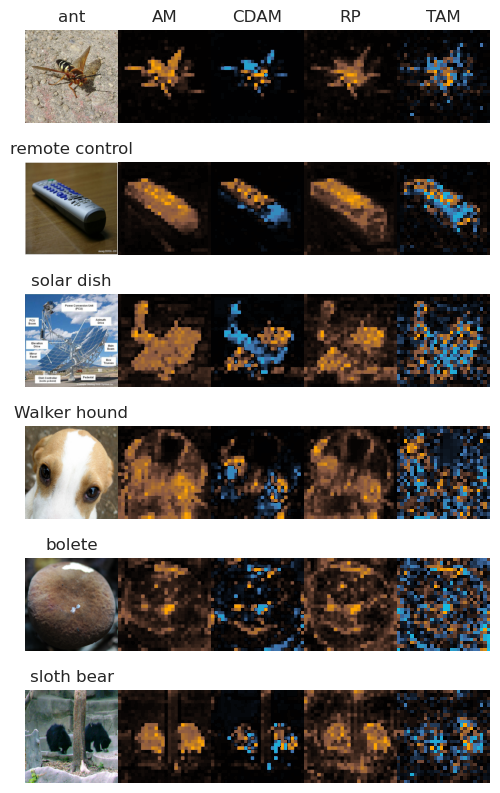

In [42]:
plot_examples(results_list)